# Segmentación semántica en dataset Kitti

Tarea # 6 Procesamiento Avanzado de Imágenes

Nombre: José Rubio

Profesor: Javier Ruiz del Solar



###Librerías

In [ ]:
import argparse
import logging
import os
import sys
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

import numpy as np
import torch
import torch.nn as nn
from torch import optim
from tqdm import tqdm

from torch.utils.data import Dataset
from PIL import Image
from os.path import splitext
from os import listdir
from glob import glob

from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import DataLoader, random_split

###Obtención de la red U-net

In [ ]:
!git clone https://github.com/milesial/Pytorch-UNet

Cloning into 'Pytorch-UNet'...
remote: Enumerating objects: 349, done.
remote: Total 349 (delta 0), reused 0 (delta 0), pack-reused 349
Receiving objects: 100% (349/349), 47.35 MiB | 40.88 MiB/s, done.
Resolving deltas: 100% (177/177), done.


In [ ]:
if not os.path.exists('unet_parts.py'):
  !wget https://raw.githubusercontent.com/milesial/Pytorch-UNet/master/unet/unet_parts.py

--2021-01-05 23:40:55--  https://raw.githubusercontent.com/milesial/Pytorch-UNet/master/unet/unet_parts.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2580 (2.5K) [text/plain]
Saving to: ‘unet_parts.py’

unet_parts.py       100%[===================>]   2.52K  --.-KB/s    in 0s      

2021-01-05 23:40:55 (60.1 MB/s) - ‘unet_parts.py’ saved [2580/2580]



In [ ]:
if not os.path.exists('unet_model.py'):
  !wget https://raw.githubusercontent.com/JossRubio/Pytorch-UNet/patch-1/unet/unet_model.py

--2021-01-05 23:40:55--  https://raw.githubusercontent.com/JossRubio/Pytorch-UNet/patch-1/unet/unet_model.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1161 (1.1K) [text/plain]
Saving to: ‘unet_model.py’

unet_model.py       100%[===================>]   1.13K  --.-KB/s    in 0s      

2021-01-05 23:40:55 (63.5 MB/s) - ‘unet_model.py’ saved [1161/1161]



In [ ]:
if not os.path.exists('eval.py'):
  !wget https://raw.githubusercontent.com/milesial/Pytorch-UNet/master/eval.py

--2021-01-05 23:40:56--  https://raw.githubusercontent.com/milesial/Pytorch-UNet/master/eval.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1073 (1.0K) [text/plain]
Saving to: ‘eval.py’

eval.py             100%[===================>]   1.05K  --.-KB/s    in 0s      

2021-01-05 23:40:56 (62.8 MB/s) - ‘eval.py’ saved [1073/1073]



In [ ]:
if not os.path.exists('dice_loss.py'):
  !wget https://raw.githubusercontent.com/milesial/Pytorch-UNet/master/dice_loss.py

--2021-01-05 23:40:56--  https://raw.githubusercontent.com/milesial/Pytorch-UNet/master/dice_loss.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1224 (1.2K) [text/plain]
Saving to: ‘dice_loss.py’

dice_loss.py        100%[===================>]   1.20K  --.-KB/s    in 0s      

2021-01-05 23:40:56 (74.2 MB/s) - ‘dice_loss.py’ saved [1224/1224]



In [ ]:
from unet_model import UNet    # Linea para cargar Unet
from eval import eval_net      # Importación de eval_net

### Descarga y extracción del Dataset Kitti.

In [ ]:
!wget https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip

--2021-01-05 23:40:56--  https://s3.eu-central-1.amazonaws.com/avg-kitti/data_semantics.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.74.92
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.74.92|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 327699796 (313M) [application/zip]
Saving to: ‘data_semantics.zip’

data_semantics.zip  100%[===================>] 312.52M  32.9MB/s    in 10s     

2021-01-05 23:41:06 (30.9 MB/s) - ‘data_semantics.zip’ saved [327699796/327699796]



In [ ]:
!unzip 'data_semantics.zip'

Archive:  data_semantics.zip
   creating: testing/
   creating: testing/image_2/
  inflating: testing/image_2/000000_10.png  
  inflating: testing/image_2/000001_10.png  
  inflating: testing/image_2/000002_10.png  
  inflating: testing/image_2/000003_10.png  
  inflating: testing/image_2/000004_10.png  
  inflating: testing/image_2/000005_10.png  
  inflating: testing/image_2/000006_10.png  
  inflating: testing/image_2/000007_10.png  
  inflating: testing/image_2/000008_10.png  
  inflating: testing/image_2/000009_10.png  
  inflating: testing/image_2/000010_10.png  
  inflating: testing/image_2/000011_10.png  
  inflating: testing/image_2/000012_10.png  
  inflating: testing/image_2/000013_10.png  
  inflating: testing/image_2/000014_10.png  
  inflating: testing/image_2/000015_10.png  
  inflating: testing/image_2/000016_10.png  
  inflating: testing/image_2/000017_10.png  
  inflating: testing/image_2/000018_10.png  
  inflating: testing/image_2/000019_10.png  
  inflating: testin

###Reducción de etiquetas

In [ ]:
# Esta funcion debe ser copiada a una celda de colaboratory para poder usarla

from numba import jit
@jit(nopython=True)
def kitty_inverse_map_1channel(img):
  cmap = [
    (0, 0), #void (ignorable) 
    (4, 0),
    (5, 0),
    (6, 0),
    (7, 1), #road
    (8, 2), #sidewalk
    (9, 2),
    (10, 0), #rail truck (ignorable)
    (11, 3), #construction
    (12, 3),
    (13, 3),
    (14, 3),
    (15, 3),
    (16, 3),
    (17, 4), #pole(s)
    (18, 4),
    (19, 5), #traffic sign
    (20, 5),
    (21, 6), #vegetation
    (22, 6),
    (23, 7),
    (24, 8), #sky
    (25, 8),
    (26, 9), #human
    (27, 9),
    (28, 9),
    (29, 9),
    (30, 9),
    (31, 10), #train
    (32, 11), #cycle
    (33, 11)
  ]  

  arrmap = np.zeros( (34), dtype=np.int32 )

  for el in cmap:
    arrmap[el[0]] = el[1]

  val = np.ones((img.shape[0],img.shape[1]), dtype=np.int32) * -1

  for i in range(img.shape[0]):
    for j in range(img.shape[1]):
      val[i,j] = arrmap[img[i,j]]
  return val

### Etiquetas de cada pixel

###Implementación del dataset

In [ ]:
class KittiDataset(Dataset):
    def __init__(self, imgs_dir, masks_dir, read_mask, scale=1, mask_suffix=''):
        super(KittiDataset, self).__init__()
        self.imgs_dir = imgs_dir
        self.masks_dir = masks_dir
        self.read_mask = read_mask
        self.scale = scale
        self.mask_suffix = mask_suffix
        assert 0 < scale <= 1, 'Scale must be between 0 and 1'

        self.ids = [splitext(file)[0] for file in listdir(imgs_dir)
                    if not file.startswith('.')]
        logging.info(f'Creating dataset with {len(self.ids)} examples')

    def __len__(self):
        return len(self.ids)

    @classmethod
    def preprocess(cls, pil_img, scale):
        w, h = pil_img.size
        newW, newH = int(scale * w), int(scale * h)
        assert newW > 0 and newH > 0, 'Scale is too small'
        pil_img = pil_img.resize((newW, newH))

        img_nd = np.array(pil_img)

        if len(img_nd.shape) == 2:
            img_nd = np.expand_dims(img_nd, axis=2)

        # HWC to CHW
        img_trans = img_nd.transpose((2, 0, 1))
        if img_trans.max() > 1:
            img_trans = img_trans / 255

        return img_trans

    def __getitem__(self, i):
        idx = self.ids[i]
        img_file = glob(self.imgs_dir + idx + '.*')
        img = Image.open(img_file[0])
        if self.read_mask:
          mask_file = glob(self.masks_dir + idx + self.mask_suffix + '.*')
          assert len(mask_file) == 1, \
              f'Either no mask or multiple masks found for the ID {idx}: {mask_file}'
          assert len(img_file) == 1, \
              f'Either no image or multiple images found for the ID {idx}: {img_file}'
          mask = Image.open(mask_file[0])

          assert img.size == mask.size, \
              f'Image and mask {idx} should be the same size, but are {img.size} and {mask.size}'
          
          mask = kitty_inverse_map_1channel(np.array(mask, dtype=np.int32))
        else:
          mask_empty = np.array([])
        img = self.preprocess(img, self.scale)
        if self.read_mask:
          return {
              'image': torch.from_numpy(img).type(torch.FloatTensor),
              'mask': torch.from_numpy(mask).type(torch.FloatTensor)
            }
        else:
          return {
              'image': torch.from_numpy(img).type(torch.FloatTensor),
              'mask': mask_empty
            }

In [ ]:
train_dir = 'training/image_2/'
mask_dir = 'training/semantic/'
test_dir = 'testing/image_2/'

###Entrenamiento de la red

In [ ]:
dir_img = 'training/image_2/'
dir_mask = 'training/semantic/'
dir_checkpoint = 'checkpoints_1/'

try:
  os.mkdir(dir_checkpoint)
  print('Created checkpoint directory')
  logging.info('Created checkpoint directory')
except OSError:
  pass


def train_net(net,
              device,
              epochs=7,
              batch_size=1,
              lr=0.001,
              val_percent=0.1,
              save_cp=True,
              img_scale=1):

    dataset = KittiDataset(imgs_dir=dir_img, masks_dir=dir_mask, read_mask=True, scale=img_scale)
    n_val = int(len(dataset) * val_percent)
    n_train = len(dataset) - n_val
    train, val = random_split(dataset, [n_train, n_val])
    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

    writer = SummaryWriter(comment=f'LR_{lr}_BS_{batch_size}_SCALE_{img_scale}')
    global_step = 0

    logging.info(f'''Starting training:
        Epochs:          {epochs}
        Batch size:      {batch_size}
        Learning rate:   {lr}
        Training size:   {n_train}
        Validation size: {n_val}
        Checkpoints:     {save_cp}
        Device:          {device}
        Images scaling:  {img_scale}
    ''')

    optimizer = optim.RMSprop(net.parameters(), lr=lr, weight_decay=1e-8, momentum=0.9)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min' if net.n_classes > 1 else 'max', patience=2)
    if net.n_classes > 1:
        criterion = nn.CrossEntropyLoss()
    else:
        criterion = nn.BCEWithLogitsLoss()

    train_loss, val_loss = [], []

    for epoch in range(epochs):
        net.train()

        epoch_loss = 0
        with tqdm(total=n_train, desc=f'Epoch {epoch + 1}/{epochs}', unit='img') as pbar:
            for batch in train_loader:
                imgs = batch['image']
                true_masks = batch['mask']
                assert imgs.shape[1] == net.n_channels, \
                    f'Network has been defined with {net.n_channels} input channels, ' \
                    f'but loaded images have {imgs.shape[1]} channels. Please check that ' \
                    'the images are loaded correctly.'

                imgs = imgs.to(device=device, dtype=torch.float32)
                mask_type = torch.float32 if net.n_classes == 1 else torch.long
                true_masks = true_masks.to(device=device, dtype=mask_type)

                masks_pred = net(imgs)
                loss = criterion(masks_pred, true_masks)
                epoch_loss += loss.item()
                writer.add_scalar('Loss/train', loss.item(), global_step)

                pbar.set_postfix(**{'loss (batch)': loss.item()})

                optimizer.zero_grad()
                loss.backward()
                nn.utils.clip_grad_value_(net.parameters(), 0.1)
                optimizer.step()

                pbar.update(imgs.shape[0])
                global_step += 1
                if global_step % (n_train // (2 * batch_size)) == 0:
                    for tag, value in net.named_parameters():
                        tag = tag.replace('.', '/')
                        writer.add_histogram('weights/' + tag, value.data.cpu().numpy(), global_step)
                        writer.add_histogram('grads/' + tag, value.grad.data.cpu().numpy(), global_step)
                    val_score = eval_net(net, val_loader, device)
                    scheduler.step(val_score)
                    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], global_step)
                    if save_cp:
                      torch.save(net.state_dict(),
                      dir_checkpoint + f'CP_middle_epoch{epoch + 1}.pth')

                    if net.n_classes > 1:
                        logging.info('Validation cross entropy: {}'.format(val_score))
                        writer.add_scalar('Loss/test', val_score, global_step)
                    else:
                        logging.info('Validation Dice Coeff: {}'.format(val_score))
                        writer.add_scalar('Dice/test', val_score, global_step)

                    writer.add_images('images', imgs, global_step)
                    if net.n_classes == 1:
                        writer.add_images('masks/true', true_masks, global_step)
                        writer.add_images('masks/pred', torch.sigmoid(masks_pred) > 0.5, global_step)
        train_loss.append(loss.item())
        val_loss.append(val_score)
        if save_cp:
            torch.save(net.state_dict(),
                       dir_checkpoint + f'CP_epoch{epoch + 1}.pth')
            print(f'Checkpoint {epoch + 1} saved !')
            logging.info(f'Checkpoint {epoch + 1} saved !')

    writer.close()

    plt.plot(range(1, epochs+1), train_loss, label='train loss')
    plt.plot(range(1, epochs+1), val_loss, label='val loss')
    plt.title('Training Loss Cross Estropy')
    plt.xlabel('Epoch')
    plt.ylabel('Loss (CE)')
    plt.grid(True)
    plt.legend()
    plt.savefig('CELoss_Train.png')
    plt.show()

Created checkpoint directory


Epoch 2/7:   0%|          | 0/180 [00:00<?, ?img/s]

Checkpoint 1 saved !


Epoch 3/7:   0%|          | 0/180 [00:00<?, ?img/s]

Checkpoint 2 saved !


Epoch 4/7:   0%|          | 0/180 [00:00<?, ?img/s]

Checkpoint 3 saved !


Epoch 5/7:   0%|          | 0/180 [00:00<?, ?img/s]

Checkpoint 4 saved !


Epoch 6/7:   0%|          | 0/180 [00:00<?, ?img/s]

Checkpoint 5 saved !


Epoch 7/7:   0%|          | 0/180 [00:00<?, ?img/s]

Checkpoint 6 saved !


Epoch 7/7: 100%|██████████| 180/180 [01:41<00:00,  1.78img/s, loss (batch)=0.597]


Checkpoint 7 saved !


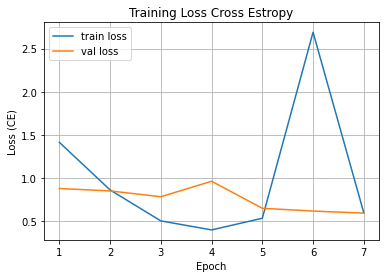

In [ ]:
net = UNet(n_channels=3, n_classes=12, bilinear=True)
net.cuda()
device = 'cuda'

try:
  train_net(net=net,
            device=device)
except KeyboardInterrupt:
  torch.save(net.state_dict(), 'INTERRUPTED.pth')
  logging.info('Saved interrupt')
  try:
    sys.exit(0)
  except SystemExit:
    os._exit(0)

###Predicciones

In [ ]:
val_percent = .1
img_scale = 1
batch_size = 1

dataset = KittiDataset(imgs_dir=dir_img, masks_dir=dir_mask, read_mask=True, scale=img_scale)
n_val = int(len(dataset) * val_percent)
n_train = len(dataset) - n_val
train, val = random_split(dataset, [n_train, n_val])
train_loader = DataLoader(train, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=False, num_workers=8, pin_memory=True, drop_last=True)

In [ ]:
len(train_loader)

180

In [ ]:
len(val_loader)

20

In [ ]:
data_test = KittiDataset(imgs_dir=test_dir, masks_dir=mask_dir, read_mask=False)
test_loader = DataLoader(data_test, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

In [ ]:
# Funcion para visualizar las imágenes predichas por el modelo.

def predict_unet(net, train_eval):
  global batch_size, train_loader, test_loader
  if train_eval:
    data_loader = train_loader
    fig, axs = plt.subplots(5,3,figsize=(11, 11))
  else:
    data_loader = test_loader
    fig, axs = plt.subplots(5,2,figsize=(11, 11))
  # data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=8, pin_memory=True)

  # fig, axs = plt.subplots(5,3,figsize=(10, 10))
  for i, data in enumerate(data_loader):
    image = data['image']
    true_image = image.numpy().transpose(2,3,1,0)
    true_image = np.squeeze(true_image)
    if train_eval:
      mask = data['mask']
      true_mask =  mask.numpy().transpose(1,2,0)
      true_mask = np.squeeze(true_mask)
    predict_mask = net(image.cuda()).cpu().detach().numpy()
    predict_mask = np.squeeze(predict_mask.transpose(2,3,1,0))
    predict_mask = np.argmax(predict_mask, axis=2)
    axs[i, 0].imshow(true_image)
    axs[i, 0].set_title('True Image RGB')
    if train_eval:
      axs[i, 1].imshow(true_mask)
      axs[i, 1].set_title('True Mask')
      axs[i, 2].imshow(predict_mask)
      axs[i, 2].set_title('Predict_Mask')
    else:
      axs[i, 1].imshow(predict_mask)
      axs[i, 1].set_title('Predict_Mask')

    if i == 4:
      break

In [ ]:
# Carga de modelos.

net_2 = UNet(n_channels=3, n_classes=12)
net_7 = UNet(n_channels=3, n_classes=12)

second_checkpoint = torch.load(dir_checkpoint + 'CP_epoch2.pth')
seventh_checkpoint = torch.load(dir_checkpoint + 'CP_epoch7.pth')

net_2.cuda()
net_7.cuda()

net_2.eval()
net_7.eval()
net_2.load_state_dict(second_checkpoint)
net_7.load_state_dict(seventh_checkpoint)

<All keys matched successfully>

###Predicciones de checkpoints

2da época

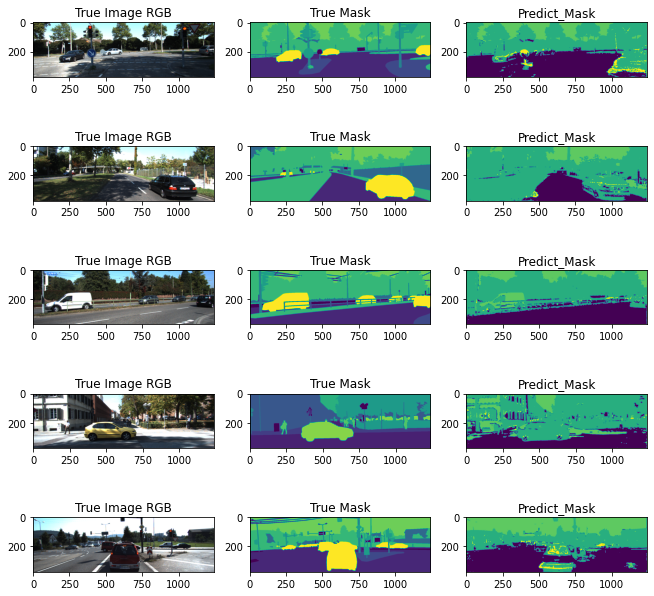

In [ ]:
predict_unet(net=net_2, train_eval=True)

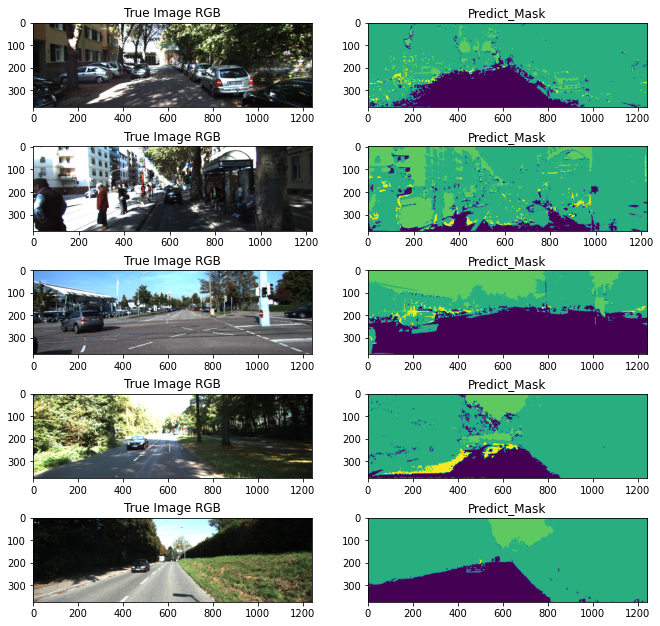

In [ ]:
predict_unet(net=net_2, train_eval=False)

7ma época

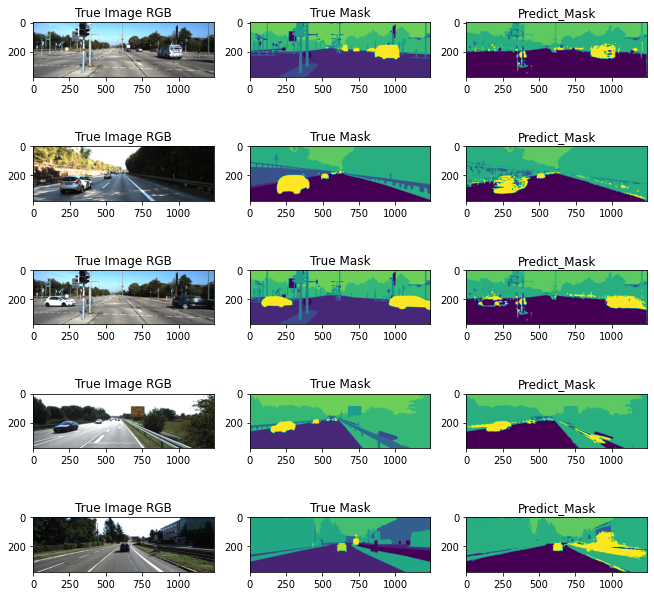

In [ ]:
predict_unet(net=net_7, train_eval=True)

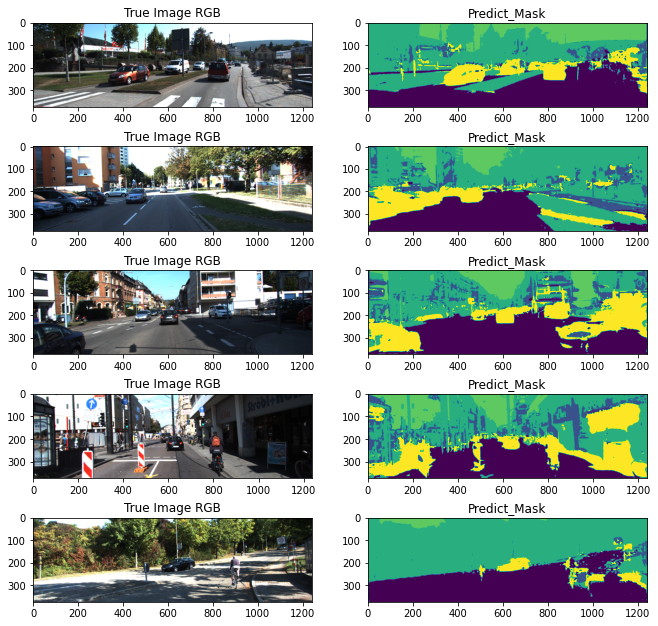

In [ ]:
predict_unet(net=net_7, train_eval=False)